<a href="https://colab.research.google.com/github/cactus1386/AI-WebScrapper/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import Libraries

In [1]:
! pip install ultralytics easyocr hezar mtcnn

In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
import easyocr
from google.colab.patches import cv2_imshow
import os
import pandas as pd
import re
from hezar.models import Model
from mtcnn.mtcnn import MTCNN

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read kibord dataset

In [4]:
import gdown
import zipfile
import os

In [ ]:
file_id = "1EP7JhNFoLtlmJCabhrpTYOkMJ2c_OyMM"
dataset_zip_path = "/content/dataset.zip"
extract_path = "/content/dataset"

In [ ]:
gdown.download(f"https://drive.google.com/uc?id={file_id}", dataset_zip_path, quiet=False)

with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset downloaded and extracted successfully!")


Downloading...
From (original): https://drive.google.com/uc?id=1EP7JhNFoLtlmJCabhrpTYOkMJ2c_OyMM
From (redirected): https://drive.google.com/uc?id=1EP7JhNFoLtlmJCabhrpTYOkMJ2c_OyMM&confirm=t&uuid=7bda8adf-0d3a-4cfe-81f7-bca300ce0e74
To: /content/dataset.zip
100%|██████████| 539M/539M [00:02<00:00, 205MB/s]


✅ Dataset downloaded and extracted successfully!


In [ ]:
print("Sample files:", os.listdir(extract_path)[:5])

Sample files: ['1488.jpg', '120.PNG', '2477.PNG', '459.PNG', '1340.jpg']


# Set model and path

In [4]:
detector = MTCNN() # set mtcnn model for face recognition
objects_model = YOLO('/content/drive/MyDrive/TextDetection.pt') # set yolo model for object detection
card_model = YOLO('/content/drive/MyDrive/CardDetection.pt') # set yolo model for card detection
ocr = easyocr.Reader(['fa']) # set persian ocr reader
hezar_ocr = Model.load("hezarai/crnn-fa-printed-96-long") # set hezar ocr model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Image Proccessing

In [4]:
import cv2

face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Rotation Code

In [9]:
def rotation(path):
    image = cv2.imread(path) # set image
    results = card_model(image) # run card yolo model for image
    if len(results[0].boxes) == 0: # if cant recognize card
        print("No card detected!")
        return None

    # set 4 corner location
    x1, y1, x2, y2 = map(int, results[0].boxes[0].xyxy[0])
    cropped_card = image[y1:y2, x1:x2]

    # check for faces
    faces = detector.detect_faces(cropped_card)
    if faces:
        x, y, w, h = faces[0]['box']
        face_center = (x + w // 2, y + h // 2) # face center location
        card_center = (cropped_card.shape[1] // 2, cropped_card.shape[0] // 2) # card center location
        angle = np.arctan2(face_center[1] - card_center[1], face_center[0] - card_center[0]) * (180 / np.pi) + 180 # angle of rotation
        rotation_matrix = cv2.getRotationMatrix2D(card_center, angle, 1.0) # make matrix for rotation
        rotated = cv2.warpAffine(cropped_card, rotation_matrix, (cropped_card.shape[1], cropped_card.shape[0])) # rotation image
        return rotated # return final image result
    else:
        # if cant find face
        return cropped_card

# Use other model for text detection (Hezar)

In [10]:
def process_img(img):
    data = {}
    results = objects_model(img) # set part of object detection yolo model

    # dict for each box conf
    box_confidences = {}

    for result in results:
        boxes = result.boxes
        for box in boxes:
            xyxy = box.xyxy[0]
            x1, y1, x2, y2 = map(int, xyxy.tolist()) # set corner locations
            label = result.names[int(box.cls)] # set label
            conf = float(box.conf)  # set conf

            cropped_img = img[max(0, y1-3):y2+3, max(0, x1-3):x2+3] # cropped image location (with more nums for better conf)
            cv2_imshow(cropped_img)

            ocr_result = hezar_ocr.predict(cropped_img)  # read text with ocr

            if ocr_result:  # check if OCR returned results
                text_list = []
                for item in ocr_result:
                    text_list.append(item['text'])
                text = " ".join(text_list)  # retrun text
            else:
                text = "" # return empty str

            # best conf text (if have more than one)
            if label in box_confidences:
                if conf > box_confidences[label][1]:
                    box_confidences[label] = (text, conf)
            else:
                box_confidences[label] = (text, conf)

    # print label, text and conf
    for label, (text, conf) in box_confidences.items():
        print(f"Label: {label}, Text: {text}, Confidence: {conf}")
        data[label] = text.strip()

    return data

# Call function and use it

In [11]:
def detect(folder):
    detected = [] # set empty list
    for img in os.listdir(folder):
      # get images from folder and set csv columns
        if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.heic')):
            img_path = os.path.join(folder, img)
            data = {'image_id': img.split('.')[0], 'national_id': '', 'first_name': '', 'last_name': '',
                    'birth_year': '', 'birth_month': '', 'birth_day': '', 'father_name': '',
                    'expiry_year': '', 'expiry_month': '', 'expiry_day': ''}

            # rotation and crop card
            card = rotation(img_path)
            if card is None:
                continue

            # extract data from cropped image
            extracted_data = process_img(card)


            # set data in dict and in csv
            for key, value in extracted_data.items():
                value = re.sub(r'\s+', ' ', value).strip() # delete space from value (we have no white space in texts)
                if key == 'Expire': # set expiry date value in dict
                    try:
                        y, m, d = value.split('/') # splite to year, month and day
                        data['expiry_year'], data['expiry_month'], data['expiry_day'] = y, m, d # set expiry day, month and year
                    except ValueError:# if cant detect "/" well and get error
                        print(f"Error splitting Expire: {value}")
                elif key == 'Birth': # set birth date value in dict
                    try:
                        y, m, d = value.split('/') # splite to year, month and day
                        data['birth_year'], data['birth_month'], data['birth_day'] = y, m, d # set birth day, month and year
                    except ValueError: # if cant detect "/" well and get error
                        print(f"Error splitting Birth: {value}")
                elif key == 'National': # set national id value in dict
                    data['national_id'] = value
                elif key == 'Name': # set name value in dict
                    data['first_name'] = value
                elif key == 'LastName': # set last name value in dict
                    data['last_name'] = value
                elif key == 'FatherName': # set father name value in dict
                    data['father_name'] = value

            detected.append(data)

    pd.DataFrame(detected).to_csv('image_phase2.csv', index=False, encoding='utf-8')
    return detected


0: 480x640 1 Card, 14.1ms
Speed: 4.2ms preprocess, 14.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.1ms
Speed: 3.9ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


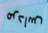

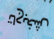

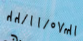

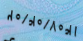

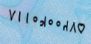

Label: FatherName, Text: ماه, Confidence: 0.8249192237854004
Label: LastName, Text: مپب-ذج, Confidence: 0.8226470947265625
Label: Birth, Text: ۰/۱۱/۰۷۱, Confidence: 0.8149757981300354
Label: Expire, Text: /۰/۸۰۰-/۲۰, Confidence: 0.8056108355522156
Label: Name, Text: به, Confidence: 0.7283305525779724
Label: National, Text: ۷/۱۰۰۰۸۵, Confidence: 0.7038185000419617
Error splitting Expire: /۰/۸۰۰-/۲۰

0: 416x640 1 Card, 26.4ms
Speed: 14.3ms preprocess, 26.4ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 640)

0: 640x576 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 16.8ms
Speed: 3.4ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


Label: National, Text: ۳۰۱۱۶۸۱۸۹۱۵۴, Confidence: 0.8878353834152222
Label: Birth, Text: ۱۳۷۱/۰۱/۱۶, Confidence: 0.8360068202018738
Label: LastName, Text: مح, Confidence: 0.8176444172859192
Label: Name, Text: شیل, Confidence: 0.8166295289993286
Label: Expire, Text: ۱۴۰۶/۱۰/۰۹, Confidence: 0.8162472248077393
Label: FatherName, Text: عاوه, Confidence: 0.8112218379974365

0: 416x640 1 Card, 14.3ms
Speed: 4.0ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 512x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 16.6ms
Speed: 3.5ms preprocess, 16.6ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Label: National, Text: ۲۰۵۹۱۴۸۸۹۹, Confidence: 0.8614752292633057
Label: Expire, Text: ۱۴۰۵/۱۲/۲۲, Confidence: 0.8440848588943481
Label: FatherName, Text: پدرام, Confidence: 0.8401737213134766
Label: LastName, Text: ندوی, Confidence: 0.835910975933075
Label: Name, Text: جنگز, Confidence: 0.8233204483985901
Label: Birth, Text: ۱۳۷۶/۰۶/۲۰, Confidence: 0.8190876841545105

0: 640x640 1 Card, 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.2ms
Speed: 4.7ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


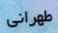

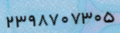

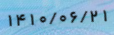

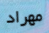

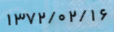

Label: LastName, Text: طهرانی, Confidence: 0.8611202239990234
Label: National, Text: ۲۳۹۸۷۰۷۳۰۵, Confidence: 0.839076042175293
Label: Expire, Text: ۱۴۱۰/۰۶/۲۱, Confidence: 0.8144144415855408
Label: FatherName, Text: مهراد, Confidence: 0.7986416816711426
Label: Name, Text: پانیذ, Confidence: 0.7921378016471863
Label: Birth, Text: ۱۳۷۲/۰۲/۱۶, Confidence: 0.7880288362503052

0: 640x448 1 Card, 13.0ms
Speed: 3.2ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x320 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 69.6ms
Speed: 2.3ms preprocess, 69.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 320)


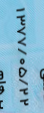

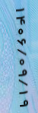

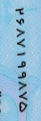

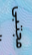

Label: Birth, Text: ه, Confidence: 0.7851657271385193
Label: Expire, Text: غ, Confidence: 0.7719516754150391
Label: National, Text: , Confidence: 0.7025980353355408
Label: LastName, Text: چ؟, Confidence: 0.6991541385650635
Label: FatherName, Text: چو, Confidence: 0.6740351915359497
Label: Name, Text: ا؟, Confidence: 0.5566384792327881
Error splitting Birth: ه
Error splitting Expire: غ

0: 416x640 1 Card, 14.2ms
Speed: 3.1ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)

0: 320x640 3 Births, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 11.9ms
Speed: 2.5ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 320, 640)


Label: Expire, Text: ۱۴۰۵/۰۱/۲۹, Confidence: 0.8694619536399841
Label: LastName, Text: پورعلی, Confidence: 0.8532020449638367
Label: National, Text: ۷۱۲۳۵۳۰۲۲۲, Confidence: 0.8411970734596252
Label: Name, Text: عارد, Confidence: 0.8160975575447083
Label: FatherName, Text: پیمان, Confidence: 0.8019728064537048
Label: Birth, Text: ۱۳۶۲/۰۵/۲۳, Confidence: 0.7789211273193359

0: 640x608 1 Card, 17.3ms
Speed: 4.1ms preprocess, 17.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

0: 640x448 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 19.8ms
Speed: 6.1ms preprocess, 19.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 448)


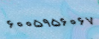

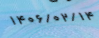

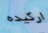

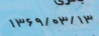

Label: National, Text: ۰۰۰۰۷۳۰۰۶۹, Confidence: 0.7974318861961365
Label: Expire, Text: ۱۴۰۰۱۰۰۱۱۴, Confidence: 0.7886755466461182
Label: Name, Text: دشده, Confidence: 0.7876738905906677
Label: FatherName, Text: هل=, Confidence: 0.743638813495636
Label: Birth, Text: ۱۷۰۹۱۰۳۱۱۳, Confidence: 0.730637788772583
Label: LastName, Text: بحد, Confidence: 0.6742050647735596
Error splitting Expire: ۱۴۰۰۱۰۰۱۱۴
Error splitting Birth: ۱۷۰۹۱۰۳۱۱۳

0: 640x576 1 Card, 17.2ms
Speed: 4.2ms preprocess, 17.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 16.8ms
Speed: 4.7ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


Label: LastName, Text: تاجیک, Confidence: 0.874995768070221
Label: Expire, Text: ۱۴۰۷/۰۹/۲۹, Confidence: 0.8459543585777283
Label: National, Text: ۸۳۶۹۷۰۷۷۰۵, Confidence: 0.8421451449394226
Label: Birth, Text: ۱۳۶۸/۰۷/۱۳, Confidence: 0.841816782951355
Label: Name, Text: مهتاب, Confidence: 0.8050323724746704
Label: FatherName, Text: آبتین, Confidence: 0.7966020107269287

0: 640x608 1 Card, 16.8ms
Speed: 4.2ms preprocess, 16.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)

0: 576x640 1 Birth, 1 Expire, 1 FatherName, 1 National, 16.8ms
Speed: 3.9ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 640)


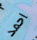

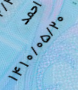

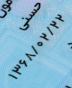

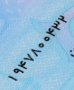

Label: FatherName, Text: خر, Confidence: 0.5670667886734009
Label: Expire, Text: خحگ, Confidence: 0.30810603499412537
Label: Birth, Text: خمححصی, Confidence: 0.2986980974674225
Label: National, Text: صح-حر, Confidence: 0.29554492235183716
Error splitting Expire: خحگ
Error splitting Birth: خمححصی

0: 640x608 1 Card, 16.1ms
Speed: 4.4ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)

0: 608x640 1 Birth, 1 Expire, 2 FatherNames, 1 LastName, 1 National, 16.9ms
Speed: 5.2ms preprocess, 16.9ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


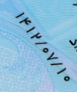

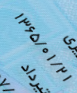

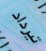

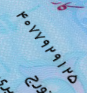

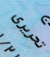

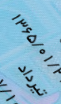

Label: Expire, Text: یر-ت, Confidence: 0.6370038986206055
Label: Birth, Text: م-ع, Confidence: 0.43369343876838684
Label: FatherName, Text: یکا, Confidence: 0.3390592932701111
Label: National, Text: پ-ی, Confidence: 0.33306339383125305
Label: LastName, Text: عمگ, Confidence: 0.31852594017982483
Error splitting Expire: یر-ت
Error splitting Birth: م-ع

0: 544x640 1 Card, 16.5ms
Speed: 3.6ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.3ms
Speed: 5.8ms preprocess, 17.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Label: FatherName, Text: ساهلن, Confidence: 0.8577094674110413
Label: Expire, Text: ۱۴۰۹/۰۸/۱۹, Confidence: 0.8438677787780762
Label: Birth, Text: ۱۳۶۷/۰۴/۰۹, Confidence: 0.8252712488174438
Label: National, Text: ۸۵۶۴۰۴۶۲۰۲, Confidence: 0.825173556804657
Label: LastName, Text: میربافری, Confidence: 0.8043156266212463
Label: Name, Text: دلیر, Confidence: 0.766039252281189

0: 544x640 1 Card, 15.7ms
Speed: 3.8ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 16.4ms
Speed: 5.5ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


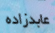

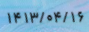

Label: LastName, Text: عابدزاده, Confidence: 0.8203519582748413
Label: Expire, Text: ۱۴۱۳/۰۴/۱۶, Confidence: 0.8174315690994263
Label: FatherName, Text: کیل, Confidence: 0.813787579536438
Label: Birth, Text: ۱۳۷۳/۱۱/۱۱, Confidence: 0.803532063961029
Label: National, Text: ۸۲۸۱۸۴۵۵۶۷, Confidence: 0.7950494289398193
Label: Name, Text: بیتا, Confidence: 0.7629387974739075

0: 640x544 1 Card, 16.7ms
Speed: 3.6ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)

0: 640x544 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 16.8ms
Speed: 4.2ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Label: National, Text: ۵۳۴۳۷۲۶۷۳۷, Confidence: 0.8947109580039978
Label: Expire, Text: ۱۴۱۴/۰۷/۲۸, Confidence: 0.8628097176551819
Label: LastName, Text: موسوی, Confidence: 0.8324447870254517
Label: FatherName, Text: آریوبرزن, Confidence: 0.8323222398757935
Label: Name, Text: آوین, Confidence: 0.8192046284675598
Label: Birth, Text: ۱۳۸۲/۰۴/۲۴, Confidence: 0.802596926689148

0: 416x640 1 Card, 15.1ms
Speed: 5.1ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 288x640 2 Births, 2 Expires, 1 FatherName, 2 LastNames, 1 Name, 1 National, 18.3ms
Speed: 2.1ms preprocess, 18.3ms inference, 4.1ms postprocess per image at shape (1, 3, 288, 640)


Label: National, Text: ۴۶۱۰۸۹۳۱۷۶, Confidence: 0.8842155933380127
Label: FatherName, Text: جلال, Confidence: 0.8530840277671814
Label: LastName, Text: خسروانی, Confidence: 0.8530220985412598
Label: Expire, Text: ۱۴۰۹/۰۷/۲۴, Confidence: 0.8482694625854492
Label: Name, Text: باک, Confidence: 0.7820792198181152
Label: Birth, Text: ۱۳۸۰/۱۲/۲۹, Confidence: 0.6947435736656189

0: 416x640 1 Card, 14.5ms
Speed: 3.4ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)

0: 576x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.2ms
Speed: 4.1ms preprocess, 17.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)


Label: National, Text: ۲۷۴۶۶۵۰۲۴۱, Confidence: 0.8637756109237671
Label: LastName, Text: عرب, Confidence: 0.8490747213363647
Label: Expire, Text: ۱۴۱۰/۰۳/۲۲, Confidence: 0.832787036895752
Label: Birth, Text: ۱۳۷۹/۰۱/۰۱, Confidence: 0.8320730924606323
Label: Name, Text: حهیرا, Confidence: 0.8006454110145569
Label: FatherName, Text: احسلن, Confidence: 0.7978735566139221

0: 640x480 1 Card, 13.8ms
Speed: 3.4ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x320 2 Expires, 3 FatherNames, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)


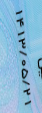

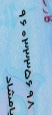

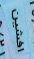

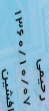

Label: Expire, Text:  ؤ, Confidence: 0.8043278455734253
Label: FatherName, Text: ا؟, Confidence: 0.5242030024528503
Error splitting Expire: ؤ

0: 512x640 1 Card, 14.1ms
Speed: 3.4ms preprocess, 14.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

0: 384x640 1 Birth, 1 Expire, 1 FatherName, 2 LastNames, 1 Name, 1 National, 12.4ms
Speed: 2.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


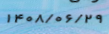

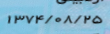

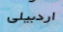

Label: National, Text: ۵۰۱۱۳۹۳۰۶۱, Confidence: 0.8215857148170471
Label: Expire, Text: ۱۴۰۸/۰۶/۲۹, Confidence: 0.7932308316230774
Label: Birth, Text: ۱۳۷۴/۰۸/۲۵, Confidence: 0.7558187246322632
Label: LastName, Text: اردبلی, Confidence: 0.7504375576972961
Label: Name, Text: حاطره, Confidence: 0.5590069890022278
Label: FatherName, Text: آرمن, Confidence: 0.3316991627216339

0: 512x640 1 Card, 13.4ms
Speed: 4.2ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 14.5ms
Speed: 4.0ms preprocess, 14.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


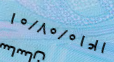

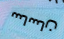

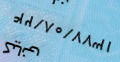

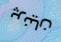

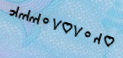

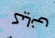

Label: Expire, Text: /ه، ه/ره مسرته, Confidence: 0.7928996086120605
Label: FatherName, Text: وه, Confidence: 0.7845670580863953
Label: Birth, Text: رههددره ا هههصو, Confidence: 0.7743391394615173
Label: Name, Text: رتبه, Confidence: 0.7341690063476562
Label: National, Text: ۷۰۷۰۷۰۷۵-ه, Confidence: 0.7110630869865417
Label: LastName, Text: مزک, Confidence: 0.6883422136306763
Error splitting Birth: رههددره ا هههصو

0: 448x640 1 Card, 14.1ms
Speed: 3.1ms preprocess, 14.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 352x640 2 Births, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 12.0ms
Speed: 2.4ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Label: Expire, Text: ۱۴۱۱/۱۱/۱۷, Confidence: 0.8611652255058289
Label: National, Text: ۴۳۰۲۷۳۸۱۴۵, Confidence: 0.8513432145118713
Label: LastName, Text: تیموری, Confidence: 0.8255897164344788
Label: FatherName, Text: داریا, Confidence: 0.8195623755455017
Label: Name, Text: فرشاد, Confidence: 0.8071306943893433
Label: Birth, Text: ۱۳۶۸/۰۲/۱۴, Confidence: 0.7701591849327087

0: 544x640 1 Card, 17.5ms
Speed: 3.9ms preprocess, 17.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 21.9ms
Speed: 4.4ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


Label: National, Text: ۹۱۸۷۶۳۹۶۹۶, Confidence: 0.8777585029602051
Label: LastName, Text: طهرانی, Confidence: 0.8677197098731995
Label: FatherName, Text: آرمان, Confidence: 0.8525095582008362
Label: Expire, Text: ۱۴۱۲/۰۷/۲۱, Confidence: 0.84966641664505
Label: Birth, Text: ۱۳۸۱/۱۱/۱۹, Confidence: 0.8072050213813782
Label: Name, Text: یوسف, Confidence: 0.7724183797836304

0: 416x640 1 Card, 13.9ms
Speed: 3.0ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 256x640 2 Births, 2 Expires, 1 FatherName, 1 LastName, 1 Name, 1 National, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 3.4ms postprocess per image at shape (1, 3, 256, 640)


Label: National, Text: ۵۰۷۳۹۹۵۴۷۶, Confidence: 0.8212894797325134
Label: LastName, Text: دسری, Confidence: 0.7817155718803406
Label: Expire, Text: ۱۴۰۶/۰۹/۲۷, Confidence: 0.7631982564926147
Label: Name, Text: مردک, Confidence: 0.7346128821372986
Label: FatherName, Text: کسری, Confidence: 0.5790801048278809
Label: Birth, Text: ۱۳۷۲/۰۳/۱۰, Confidence: 0.5401924848556519

0: 416x640 1 Card, 12.9ms
Speed: 2.9ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)

0: 512x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 15.0ms
Speed: 6.5ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


Label: National, Text: ۴۸۹۵۴۰۸۴۷۹, Confidence: 0.8548929691314697
Label: Birth, Text: ۱۳۶۷/۰۸/۰۸, Confidence: 0.836208164691925
Label: Expire, Text: ۱۴۰۸/۱۱/۲۴, Confidence: 0.8316501975059509
Label: FatherName, Text: آرتا, Confidence: 0.820364773273468
Label: Name, Text: صابر, Confidence: 0.8163337707519531
Label: LastName, Text: گوهری, Confidence: 0.814655601978302

0: 640x416 1 Card, 15.1ms
Speed: 2.9ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 416)

0: 640x320 1 Birth, 1 Expire, 2 FatherNames, 1 LastName, 1 Name, 1 National, 15.0ms
Speed: 2.5ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 320)


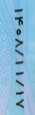

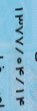

Label: Expire, Text: چ, Confidence: 0.7628605365753174
Label: Birth, Text: چ, Confidence: 0.7607152462005615
Label: LastName, Text: , Confidence: 0.7413729429244995
Label: National, Text: د, Confidence: 0.6376309990882874
Label: Name, Text: أ, Confidence: 0.6269609928131104
Label: FatherName, Text: چا, Confidence: 0.515842854976654
Error splitting Expire: چ
Error splitting Birth: چ

0: 416x640 1 Card, 16.6ms
Speed: 3.5ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 224x640 2 Births, 2 Expires, 1 FatherName, 1 LastName, 1 Name, 1 National, 14.3ms
Speed: 2.4ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 640)


Label: Expire, Text: ۱۴۱۰/۰۲/۲۱, Confidence: 0.7628844380378723
Label: National, Text: ۲۸۶۰۲۴۴۰۰۷, Confidence: 0.7611321806907654
Label: Name, Text: آتاهیتا, Confidence: 0.6613955497741699
Label: LastName, Text: منصوری, Confidence: 0.6386616826057434
Label: Birth, Text: ۱۳۸۳/۰۲/۲۲, Confidence: 0.57956862449646
Label: FatherName, Text: کامبخس, Confidence: 0.47411516308784485

0: 608x640 1 Card, 17.2ms
Speed: 4.1ms preprocess, 17.2ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.4ms
Speed: 3.8ms preprocess, 17.4ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 640)


Label: National, Text: ۷۳۷۹۶۹۲۰۷۷, Confidence: 0.8667492270469666
Label: LastName, Text: پاینده, Confidence: 0.8660451173782349
Label: Expire, Text: ۱۴۰۹/۰۷/۰۵, Confidence: 0.8587115406990051
Label: FatherName, Text: توران, Confidence: 0.8490884304046631
Label: Birth, Text: ۱۳۶۰/۰۷/۱۵, Confidence: 0.8150109052658081
Label: Name, Text: سعید, Confidence: 0.7859237790107727

0: 640x576 1 Card, 17.3ms
Speed: 4.4ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)

0: 640x576 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.2ms
Speed: 3.9ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


Label: National, Text: ۹۰۳۸۶۲۸۱۹۹, Confidence: 0.8907327055931091
Label: LastName, Text: دارابی, Confidence: 0.8656250834465027
Label: FatherName, Text: افراز, Confidence: 0.8567572832107544
Label: Expire, Text: ۱۴۱۵/۱۲/۲۳, Confidence: 0.8484026193618774
Label: Birth, Text: ۱۳۸۴/۰۳/۱۵, Confidence: 0.8191317915916443
Label: Name, Text: یغما, Confidence: 0.7995419502258301

0: 640x480 1 Card, 13.3ms
Speed: 3.4ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 15.2ms
Speed: 5.3ms preprocess, 15.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


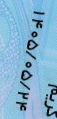

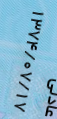

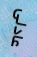

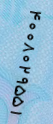

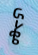

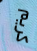

Label: Expire, Text: رغ, Confidence: 0.8096874952316284
Label: Birth, Text: =خجی, Confidence: 0.8081311583518982
Label: LastName, Text: گ, Confidence: 0.7961295247077942
Label: National, Text: خخیه, Confidence: 0.7622609734535217
Label: Name, Text: گچ, Confidence: 0.6898300647735596
Label: FatherName, Text: ه, Confidence: 0.67353755235672
Error splitting Expire: رغ
Error splitting Birth: =خجی

0: 480x640 1 Card, 14.3ms
Speed: 3.1ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 352x640 3 Births, 1 Expire, 1 FatherName, 2 LastNames, 1 Name, 1 National, 11.8ms
Speed: 2.9ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)


Label: LastName, Text: اشرفی, Confidence: 0.8334869742393494
Label: Expire, Text: ۱۴۰۷/۰۸/۱۳, Confidence: 0.8282739520072937
Label: National, Text: ۴۲۰۸۲۹۵۷۴۴, Confidence: 0.8221206068992615
Label: Name, Text: مجت, Confidence: 0.7699734568595886
Label: FatherName, Text: کامیار, Confidence: 0.6205098032951355
Label: Birth, Text: ۱۳۷۵/۰۳/۲۳, Confidence: 0.5012416839599609

0: 416x640 1 Card, 13.9ms
Speed: 3.8ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 640x576 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 18.3ms
Speed: 3.9ms preprocess, 18.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 576)


Label: National, Text: ۵۳۹۸۱۲۵۰۱۱, Confidence: 0.8787297606468201
Label: Birth, Text: ۱۳۰۳/۰۶/۴۲, Confidence: 0.8412231802940369
Label: Name, Text: سژن, Confidence: 0.8300150036811829
Label: FatherName, Text: افراز, Confidence: 0.8226874470710754
Label: LastName, Text: محففی, Confidence: 0.8216508030891418
Label: Expire, Text: ۱۴۱۳/۰۱/۰۵, Confidence: 0.7923010587692261

0: 640x576 1 Card, 17.1ms
Speed: 4.3ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 576)

0: 640x384 1 Expire, 1 FatherName, 50.3ms
Speed: 4.3ms preprocess, 50.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


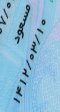

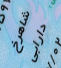

Label: Expire, Text: حم , Confidence: 0.6769008636474609
Label: FatherName, Text: د مو گه, Confidence: 0.2882203459739685
Error splitting Expire: حم

0: 416x640 1 Card, 44.3ms
Speed: 3.5ms preprocess, 44.3ms inference, 6.1ms postprocess per image at shape (1, 3, 416, 640)

0: 640x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 23.2ms
Speed: 5.0ms preprocess, 23.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Label: LastName, Text: ادیب, Confidence: 0.8534887433052063
Label: National, Text: ۲۴۲۷۹۸۳۶۲۰, Confidence: 0.849140465259552
Label: Birth, Text: ۱۳۸۰/۰۹/۰۳, Confidence: 0.8229959011077881
Label: Expire, Text: ۱۴۰۹/۰۸/۰۶, Confidence: 0.8196995258331299
Label: Name, Text: اوشه, Confidence: 0.8068808913230896
Label: FatherName, Text: چنگز, Confidence: 0.7901967763900757

0: 640x640 1 Card, 31.5ms
Speed: 8.5ms preprocess, 31.5ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x416 (no detections), 45.6ms
Speed: 8.3ms preprocess, 45.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 416)

0: 416x640 1 Card, 38.4ms
Speed: 3.0ms preprocess, 38.4ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 256x640 2 Births, 2 Expires, 1 FatherName, 1 LastName, 1 Name, 1 National, 39.1ms
Speed: 8.2ms preprocess, 39.1ms inference, 2.3ms postprocess per image at shape (1, 3, 256, 640)


Label: National, Text: ۸۰۷۸۶۳۳۲۰۵, Confidence: 0.8470801711082458
Label: Expire, Text: ۱۴۰۵/۰۹/۲۷, Confidence: 0.7229015827178955
Label: LastName, Text: سعادت, Confidence: 0.7042677998542786
Label: Birth, Text: ۱۳۸۲/۰۸/۰۱, Confidence: 0.6001794338226318
Label: FatherName, Text: دانیال, Confidence: 0.5302706956863403
Label: Name, Text: مسعودعلی, Confidence: 0.3257836103439331

0: 416x640 1 Card, 14.2ms
Speed: 6.6ms preprocess, 14.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 640x576 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.0ms
Speed: 3.5ms preprocess, 17.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 576)


Label: National, Text: ۷۰۱۰۱۳۶۱۸۱۱, Confidence: 0.8592959046363831
Label: LastName, Text: شاهی, Confidence: 0.8376184701919556
Label: FatherName, Text: فب, Confidence: 0.8357101678848267
Label: Birth, Text: ۱۳/۹/۱۰/۱۵, Confidence: 0.8180493712425232
Label: Expire, Text: ۱۴۰۶/۰۴/۰۴, Confidence: 0.8086534142494202
Label: Name, Text: رحم, Confidence: 0.7432568669319153
Error splitting Birth: ۱۳/۹/۱۰/۱۵

0: 640x640 1 Card, 35.3ms
Speed: 8.5ms preprocess, 35.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 16.0ms
Speed: 5.6ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


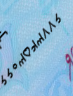

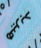

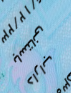

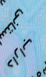

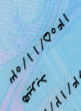

Label: National, Text: ه ت حححه ح-ه, Confidence: 0.6090855598449707
Label: FatherName, Text: مه, Confidence: 0.44688600301742554
Label: LastName, Text: هح عه ت, Confidence: 0.29937025904655457
Label: Name, Text: حعه , Confidence: 0.28713464736938477
Label: Expire, Text: ذهر-, Confidence: 0.2712540626525879
Error splitting Expire: ذهر-

0: 416x640 1 Card, 14.1ms
Speed: 2.8ms preprocess, 14.1ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 576x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.1ms
Speed: 4.7ms preprocess, 17.1ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 640)


Label: Birth, Text: ۱۳۷۲/۰۶/۱۴, Confidence: 0.8555560111999512
Label: National, Text: ۳۱۱۰۹۵۵۳۲۱, Confidence: 0.8499235510826111
Label: Name, Text: مهرآبین, Confidence: 0.8346474766731262
Label: LastName, Text: سعادت, Confidence: 0.830787718296051
Label: Expire, Text: ۱۴۱۳/۱۱/۲۴, Confidence: 0.81253981590271
Label: FatherName, Text: پورا, Confidence: 0.7875682711601257

0: 640x448 1 Card, 13.2ms
Speed: 3.5ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 25.9ms
Speed: 13.7ms preprocess, 25.9ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 448)


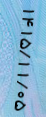

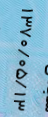

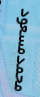

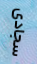

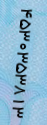

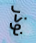

Label: Expire, Text: تی, Confidence: 0.8301443457603455
Label: Birth, Text: فچ, Confidence: 0.8034334182739258
Label: FatherName, Text: چ , Confidence: 0.7840021848678589
Label: LastName, Text: ت, Confidence: 0.7722765207290649
Label: National, Text: خ, Confidence: 0.7617452144622803
Label: Name, Text: بچاّ, Confidence: 0.7416031360626221
Error splitting Expire: تی
Error splitting Birth: فچ

0: 640x480 1 Card, 19.8ms
Speed: 3.8ms preprocess, 19.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x384 1 Birth, 2 Expires, 1 FatherName, 1 LastName, 1 Name, 25.4ms
Speed: 3.2ms preprocess, 25.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


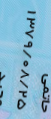

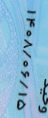

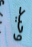

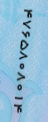

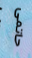

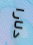

Label: Birth, Text: ج, Confidence: 0.7828792929649353
Label: Expire, Text: ر, Confidence: 0.7732641696929932
Label: FatherName, Text: ث, Confidence: 0.5852928757667542
Label: LastName, Text: , Confidence: 0.48341190814971924
Label: Name, Text: ا, Confidence: 0.2576411962509155
Error splitting Birth: ج
Error splitting Expire: ر

0: 416x640 1 Card, 14.0ms
Speed: 8.0ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 640)

0: 320x640 2 Births, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 15.0ms
Speed: 2.4ms preprocess, 15.0ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


Label: LastName, Text: ندوی, Confidence: 0.8696361184120178
Label: Expire, Text: ۱۴۱۳/۰۱/۲۳, Confidence: 0.8590071201324463
Label: Name, Text: جمال, Confidence: 0.8435338139533997
Label: FatherName, Text: فواد, Confidence: 0.838710606098175
Label: National, Text: ۸۸۱۷۱۸۸۸۴۲, Confidence: 0.8317857384681702
Label: Birth, Text: ۱۳۸۳/۰۶/۱۶, Confidence: 0.7915395498275757

0: 416x640 1 Card, 15.7ms
Speed: 2.9ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)

0: 320x640 2 Births, 2 Expires, 1 FatherName, 1 LastName, 1 Name, 1 National, 11.3ms
Speed: 2.8ms preprocess, 11.3ms inference, 2.5ms postprocess per image at shape (1, 3, 320, 640)


Label: Expire, Text: ۱۴۱۵/۰۴/۲۹, Confidence: 0.8604296445846558
Label: National, Text: ۸۲۵۹۳۴۷۱۴۸, Confidence: 0.8400806784629822
Label: LastName, Text: یوسفی, Confidence: 0.831554114818573
Label: Name, Text: فرهاد, Confidence: 0.802630603313446
Label: Birth, Text: ۱۳۸۲/۰۵/۰۳, Confidence: 0.7923321723937988
Label: FatherName, Text: کیخسرو, Confidence: 0.7680427432060242

0: 416x640 1 Card, 12.8ms
Speed: 3.9ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)

0: 256x640 3 Births, 2 Expires, 1 FatherName, 1 LastName, 1 Name, 1 National, 12.7ms
Speed: 2.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 640)


Label: National, Text: ۹۶۳۹۴۵۷۹۴۵, Confidence: 0.8392201662063599
Label: Expire, Text: ۱۴۱۴/۰۷/۰۸, Confidence: 0.8272437453269958
Label: FatherName, Text: رامتبن, Confidence: 0.7493006587028503
Label: LastName, Text: کاشفی, Confidence: 0.7164654731750488
Label: Name, Text: پرهام, Confidence: 0.6916489005088806
Label: Birth, Text: ۱۳۶۵/۰۹/۲۵, Confidence: 0.5649521350860596

0: 640x512 1 Card, 13.2ms
Speed: 4.2ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 16.3ms
Speed: 4.0ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


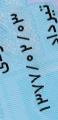

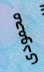

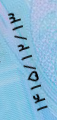

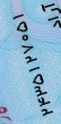

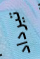

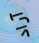

Label: Birth, Text: د, Confidence: 0.8676509261131287
Label: LastName, Text: ی, Confidence: 0.8416973352432251
Label: Expire, Text: , Confidence: 0.8282986879348755
Label: National, Text: ظ, Confidence: 0.7841350436210632
Label: FatherName, Text: أ, Confidence: 0.7541927695274353
Label: Name, Text: تآ, Confidence: 0.7181954383850098
Error splitting Birth: د
Error splitting Expire: 

0: 640x608 1 Card, 17.9ms
Speed: 3.8ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)

0: 512x640 1 Expire, 1 FatherName, 14.7ms
Speed: 3.6ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


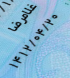

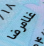

Label: Expire, Text: جم, Confidence: 0.7064051032066345
Label: FatherName, Text: حچ, Confidence: 0.5993740558624268
Error splitting Expire: جم

0: 640x608 1 Card, 16.1ms
Speed: 4.6ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)

0: 640x608 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.2ms
Speed: 5.3ms preprocess, 17.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


Label: National, Text: ۶۱۵۹۱۵۷۸۴۵, Confidence: 0.8756160736083984
Label: LastName, Text: صدری, Confidence: 0.8580197095870972
Label: Expire, Text: ۱۴۱۴/۱۰/۲۶, Confidence: 0.8575778007507324
Label: Name, Text: افراسیاب, Confidence: 0.8374515175819397
Label: FatherName, Text: گودرز, Confidence: 0.832171618938446
Label: Birth, Text: ۱۳۷۶/۱۱/۲۸, Confidence: 0.8154842853546143

0: 416x640 1 Card, 13.9ms
Speed: 3.2ms preprocess, 13.9ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 256x640 1 Birth, 2 Expires, 1 FatherName, 1 LastName, 1 Name, 1 National, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 640)


Label: Expire, Text: ۱۴۱۴/۱۲/۲۵, Confidence: 0.8447844982147217
Label: National, Text: ۶۰۸۳۷۸۰۶۵۱, Confidence: 0.8311541676521301
Label: FatherName, Text: اتن, Confidence: 0.7901573777198792
Label: LastName, Text: قربائی, Confidence: 0.7771816253662109
Label: Name, Text: پرئیان, Confidence: 0.7766937613487244
Label: Birth, Text: ۱۳۶۳/۰۷/۱۵, Confidence: 0.6642910838127136

0: 512x640 1 Card, 14.2ms
Speed: 3.7ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

0: 480x640 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 14.8ms
Speed: 3.2ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


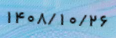

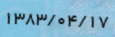

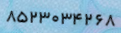

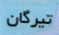

Label: LastName, Text: ملک, Confidence: 0.8163629174232483
Label: Expire, Text: ۱۴۰۸/۱۰/۲۶, Confidence: 0.8112325072288513
Label: Birth, Text: ۱۳۸۳/۰۴/۱۷, Confidence: 0.7989330291748047
Label: National, Text: ۸۵۲۳۰۳۴۲۶۸, Confidence: 0.7785120010375977
Label: Name, Text: مهدی, Confidence: 0.7695698142051697
Label: FatherName, Text: تیرگان, Confidence: 0.7555750012397766

0: 544x640 1 Card, 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

0: 640x608 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 17.1ms
Speed: 4.0ms preprocess, 17.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


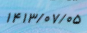

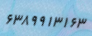

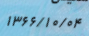

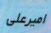

Label: LastName, Text: سعدی, Confidence: 0.8251935839653015
Label: Expire, Text: ۳/۰۷/۰۵///, Confidence: 0.8173289895057678
Label: National, Text: سو/سر/وو%س۶, Confidence: 0.7917125821113586
Label: Birth, Text: /۰/۰//۶۶//, Confidence: 0.7757740616798401
Label: Name, Text: منووهر, Confidence: 0.7735833525657654
Label: FatherName, Text: /صرلی, Confidence: 0.5494819283485413
Error splitting Expire: ۳/۰۷/۰۵///
Error splitting Birth: /۰/۰//۶۶//

0: 640x448 1 Card, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 Birth, 1 Expire, 1 FatherName, 1 LastName, 1 Name, 1 National, 13.3ms
Speed: 3.2ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


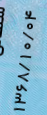

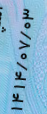

KeyboardInterrupt: 

In [12]:
detect('/content/drive/MyDrive/images/')

# Sort csv

In [ ]:
df = pd.read_csv('image_phase2.csv')
df = df.sort_values(by='image_id')
df.to_csv("image_phase2.csv", index=False)

In [ ]:
df